In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

## Import data

In [3]:
ETF_file = 'oct-2017-data/GBPJPY_H4.csv'
ETF_plus_1_file = 'oct-2017-data/GBPJPY_D1.csv'

# symbol settings
ETF_TimeFrame = "H4" # Important to input correctly (ex: M1,M5,M15,M30,H1,H4,D1,W1,MN1)
ETF_plus_1_TimeFrame = "D1"

In [4]:
df_ETF = pd.read_csv(ETF_file)
df_ETF.columns = ["Date", "O", "H", "L", "C",]
df_ETF["Date"] = pd.to_datetime(df_ETF["Date"], unit='s')
df_ETF = df_ETF.set_index('Date')
df_ETF = df_ETF.sort_index()
df_ETF['Date'] = df_ETF.index
df_ETF.reset_index(drop=True, inplace=True)

In [5]:
df_ETF_plus_1 = pd.read_csv(ETF_plus_1_file)
df_ETF_plus_1.columns = ["Date", "O", "H", "L", "C",]
df_ETF_plus_1["Date"] = pd.to_datetime(df_ETF_plus_1["Date"], unit='s')
df_ETF_plus_1 = df_ETF_plus_1.set_index('Date')
df_ETF_plus_1 = df_ETF_plus_1.sort_index()
df_ETF_plus_1['Date'] = df_ETF_plus_1.index
df_ETF_plus_1.reset_index(drop=True, inplace=True)

In [6]:
df_ETF.tail()

,O,H,L,C,Date
1189,149.191,149.345,149.108,149.302,2017-10-05 04:00:00
1190,149.301,149.345,148.443,148.527,2017-10-05 08:00:00
1191,148.526,148.627,147.679,147.708,2017-10-05 12:00:00
1192,147.708,148.189,147.679,148.080,2017-10-05 16:00:00
1193,148.080,148.118,147.865,147.976,2017-10-05 20:00:00


In [7]:
df_ETF_plus_1.tail()

,O,H,L,C,Date
194,150.968,151.277,150.199,150.671,2017-09-29
195,150.617,150.963,149.274,149.624,2017-10-02
196,149.657,150.235,149.286,149.286,2017-10-03
197,149.272,149.901,149.035,149.316,2017-10-04
198,149.343,149.454,147.679,147.974,2017-10-05


## Trade logic / strategy to setup the trade

### Placeholder strategy

In [8]:
#Average Directional Movement Index  
def ADX(df, n, n_ADX):  
    i = 0  
    UpI = []  
    DoI = []  
    while i + 1 <= df.index[-1]:  
        UpMove = df.get_value(i + 1, 'H') - df.get_value(i, 'H')  
        DoMove = df.get_value(i, 'L') - df.get_value(i + 1, 'L')  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'H'), df.get_value(i, 'C')) - min(df.get_value(i + 1, 'L'), df.get_value(i, 'C'))  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(pd.ewma(TR_s, span = n, min_periods = n))  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(pd.ewma(UpI, span = n, min_periods = n - 1) / ATR)  
    NegDI = pd.Series(pd.ewma(DoI, span = n, min_periods = n - 1) / ATR)  
    ADX = pd.Series(pd.ewma(abs(PosDI - NegDI) / (PosDI + NegDI), span = n_ADX, min_periods = n_ADX - 1), name = 'ADX_' + str(n) + '_' + str(n_ADX))  
    df = df.join(ADX)  
    return df

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=10,span=10,adjust=True,ignore_na=False).mean()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:28: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=9,span=10,adjust=True,ignore_na=False).mean()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:29: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=9,span=10,adjust=True,ignore_na=False).mean()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: pd.ewm_mean is deprecated for Series 

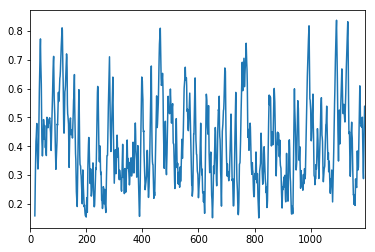

In [9]:
ADX(df_ETF, 10, 10)['ADX_10_10'].plot()

In [19]:
def setup_trade(df_ETF, df_ETF_plus_1):
    for each in ['TRADE_IT', 'Stop Loss', 'Entry Price', 
                 'Target Price 1', 'Target Price 2', 'Type of Trade', 
                 'Pct of Portfolio', 'TP1 vs TP2 Split']:
        df_ETF[each] = np.NaN
    
    df_ETF = ADX(df_ETF, 10, 10)
    most_recent_zone_index = int(df_ETF.index[-1])
    print(type(most_recent_zone_index))
    trade_setup_dict = {}
    
    # Set Trade to yes for the last row, telling us later to use this row to trade off
    df_ETF.loc[most_recent_zone_index, 'TRADE_IT'] = True

    df_ETF.loc[most_recent_zone_index, 'Stop Loss'] = round(df_ETF.iloc[most_recent_zone_index]['L'], 3)
    trade_setup_dict['Stop Loss'] = round(df_ETF.iloc[most_recent_zone_index]['L'], 3)

    entry_price = round((df_ETF.loc[most_recent_zone_index, 'O'] + df_ETF.loc[most_recent_zone_index, 'O'])/2, 3)
    df_ETF.loc[most_recent_zone_index, 'Entry Price'] = entry_price
    trade_setup_dict['Entry Price'] = entry_price
    
    if df_ETF.iloc[most_recent_zone_index]['ADX_10_10'] > 0.5:
        target_multiplier = 1 #set to positive
    elif df_ETF.iloc[most_recent_zone_index]['ADX_10_10'] <= 0.5:
        target_multiplier = -1 #set to negative

    # Find target price 1
    if target_multiplier > 0:
        target_price_1 = df_ETF.iloc[most_recent_zone_index]['H']*1.1
    elif target_multiplier < 0:
        target_price_1 = df_ETF.iloc[most_recent_zone_index]['L']*0.9
    target_price_1 = round(target_price_1, 3)
    df_ETF.loc[most_recent_zone_index, 'Target Price 1'] = target_price_1
    trade_setup_dict['Target Price 1'] = target_price_1

    # Find target price 1
    if target_multiplier > 0:
        target_price_2 = df_ETF.iloc[most_recent_zone_index]['H']*1.25
    elif target_multiplier < 0:
        target_price_2 = df_ETF.iloc[most_recent_zone_index]['L']*0.75
    target_price_2 = round(target_price_2, 3)
    df_ETF.loc[most_recent_zone_index, 'Target Price 2'] = target_price_2
    trade_setup_dict['Target Price 2'] = target_price_2

    # 'Type of Trade'
    if target_multiplier > 0:
        df_ETF.loc[most_recent_zone_index, 'Type of Trade'] = 'LONG'
        trade_setup_dict['Type of Trade'] = 'LONG'
    elif target_multiplier < 0:
        df_ETF.loc[most_recent_zone_index, 'Type of Trade'] = 'SHORT'
        trade_setup_dict['Type of Trade'] = 'SHORT'

    # 'Pct of Portfolio'
    # For now let's just say we use 0.03 of our available cash every time, in the future we can optimize 
    df_ETF.loc[most_recent_zone_index, 'Pct of Portfolio'] = 0.03
    trade_setup_dict['Pct of Portfolio'] = 0.03

    # 'TP1 vs TP2 Split'
    # For now let's just say we split 50% of the trade between TP1 and TP2, in the future we can optimize 
    df_ETF.loc[most_recent_zone_index, 'TP1 vs TP2 Split'] = 0.5
    trade_setup_dict['TP1 vs TP2 Split'] = 0.5
    
    # Save index of which zone we traded off
    trade_setup_dict['zone_index'] = most_recent_zone_index

    return trade_setup_dict

In [20]:
trade_setup_dict = setup_trade(df_ETF, df_ETF_plus_1)

<class 'int'>


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=10,span=10,adjust=True,ignore_na=False).mean()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:28: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=9,span=10,adjust=True,ignore_na=False).mean()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:29: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=9,span=10,adjust=True,ignore_na=False).mean()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: pd.ewm_mean is deprecated for Series 

In [21]:
# Outputs a dictionary
trade_setup_dict

{'Entry Price': 148.08000000000001,
 'Pct of Portfolio': 0.03,
 'Stop Loss': 147.86500000000001,
 'TP1 vs TP2 Split': 0.5,
 'Target Price 1': 162.93000000000001,
 'Target Price 2': 185.14699999999999,
 'Type of Trade': 'LONG',
 'zone_index': 1193}